In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from atomsci.ddm.pipeline import diversity_plots as dp
from scipy.spatial.distance import pdist, squareform
import matplotlib.patches as mpatches

Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [ ]:
# method to translate ecfp fingerprints in DF back to bitvectors
from rdkit.DataStructs import ExplicitBitVect
def df_to_bitvect(df):
    bitvects = []
    for _, row in df.iterrows():
        bit_string = ''.join(row.astype(str))
        bitvect = ExplicitBitVect(len(bit_string))
        for i, bit in enumerate(bit_string):
            if bit == '1':
                bitvect.SetBit(i)
        bitvects.append(bitvect)
    return bitvects

In [2]:
from atomsci.ddm.pipeline import chem_diversity as cd
from atomsci.ddm.pipeline import dist_metrics
import logging
import pandas as pd
import matplotlib.pyplot as plt

def plot_tani_dist_distr(df, smiles_col, df_name, radius=2, featurized=False, subset_col='subset', subsets=False, ref_subset='train', plot_width=6, ndist_max=None, **metric_kwargs):
    """Generate a density plot showing the distribution of nearest neighbor distances between
    ecfp feature vectors, using the Tanimoto metric. Optionally split by subset.
    Args:
        df (DataFrame): A data frame containing, at minimum, a column of SMILES strings.
        smiles_col (str): Name of the column containing SMILES strings.
        df_name (str): Name for the dataset, to be used in the plot title.
        radius (int): Radius parameter used to calculate ECFP fingerprints. The default is 2, meaning that ECFP4 fingerprints are calculated.
        featurized (bool): If True, the input data frame contains precomputed features. If False, features are calculated on the fly.
        subset_col (str): Name of the column containing subset names.
        subsets (bool): If True, distances are only calculated for compounds not in the reference subset, and the distances computed are to the nearest neighbors in the reference subset.
        ref_subset (str): Reference subset for nearest-neighbor distances, if `subsets` is True.
        plot_width (float): Plot width in inches.
        ndist_max (int): Not used, included only for backward compatibility.
        metric_kwargs: Additional arguments to pass to metric. Not used, included only for backward compatibility.
    Returns:
        dist (DataFrame): Table of individual nearest-neighbor Tanimoto distance values. If subsets is True,
        the table will include a column indicating the subset each compound belongs to.
    """
    log = logging.getLogger('ATOM')
    
    num_cmpds = len(df)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    if subsets and subset_col not in df.columns:
        log.warning(f"{subset_col} column not found. Calculating total tanimoto distances instead.")
        subsets=False
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    calc_type='nearest'
    num_nearest=1
    if not subsets:
        smiles_arr1 = df[smiles_col].values
        if not featurized:
            dists=cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr1, calc_type=calc_type, num_nearest=num_nearest)
        else:
            fprints1_df = df[[col for col in df.columns if 'ecfp' in col]]
            fprints1=df_to_bitvect(fprints1_df)
            fprints2 = None
            within_dset = True
            dists=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
            
        # flatten dists
        dists = dists.flatten()
        subs=['all']*len(dists)
        dists=pd.DataFrame(zip(dists,subs), columns=['dist','subset'])
    elif subsets:
        dists=pd.DataFrame([], columns=['dist','subset'])
        for subs in df[subset_col].unique():
            if subs==ref_subset:
                continue
            if not featurized:
                smiles_arr1 = df.loc[df[subset_col]==ref_subset, smiles_col].values
                smiles_arr2 = df.loc[df[subset_col]==subs, smiles_col].values
                diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type=calc_type, num_nearest=num_nearest)
            else:
                fprints1_df=df.loc[df['subset']==ref_subset, [col for col in df.columns if 'ecfp' in col]]
                fprints2_df=df.loc[df['subset']==subs, [col for col in df.columns if 'ecfp' in col]]
                print(subs)
                
                fprints1=df_to_bitvect(fprints1_df)
                fprints2=df_to_bitvect(fprints2_df)
                

                within_dset=False
                diststmp=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
    
            # flatten dists
            diststmp = diststmp.flatten()
    
            substmp=[subs]*len(diststmp)
            diststmp = pd.DataFrame(zip(diststmp,substmp), columns=['dist',subset_col])
            dists=pd.concat([dists,diststmp])
    
    dists=dists.reset_index(drop=True)
    fig, ax = plt.subplots(1, figsize=(plot_width, plot_width), dpi=300)
    sns.kdeplot(data=dists[dists.subset!=ref_subset], x='dist', hue=subset_col, legend=True, common_norm=False, common_grid=False, fill=False, ax=ax)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    if not subsets:
        ax.set_title("%s dataset\nDistribution of %s nearest neighbor distances between %s feature vectors" % (
                      df_name, dist_metric, feat_type))
    else: 
        ax.set_title(f"{df_name} dataset: Distribution of {dist_metric} distances\nbetween {feat_type} feature vectors from non-{ref_subset} subsets\nto their nearest neighbors in the {ref_subset} subset")
    plt.show(); 
    return dists, fig, ax

In [16]:
colors = ["#6EC8BE","#BE2369","#FFC30F","#694691","#EB1E23","#7682A4","#373C50","#A7DDD8",]
sns.set_palette(sns.color_palette(colors))
def plot_corr_matrices_ecfp_traintest(dfs, dflabs,
                    firstcols = "ecfp_2048_0", 
                    lastcols = "ecfp_2048_2047", 
                    rowlabelcols = 'subset',
                    collabelcols='active',
                    dataset_names = ['train vs. test']):
    '''
    pass in a list of dataframes with associated labels, the columns to subset on for computing the UMAP, and which columns should reflect the labels and values
    computes umap and returns a strip of UMAP plots using each item in each list
    '''
    corr_dfs=[]
    figs = []
    for i, df in enumerate(dfs):
        print("Computing correlation matrix for", dflabs[i])
        # df=df.set_index([rowlabelcols[i]])
        # map_df = df.loc[:,firstcols[i]:lastcols[i]]
        df = df.set_index(rowlabelcols)
        map_df = df.loc[:, firstcols:lastcols]
        
        corr_matrix = pd.DataFrame(squareform(pdist(map_df, metric='jaccard')), columns=map_df.index, index=map_df.index)


        unique_rows = df.index.unique()
        unique_cols = df[collabelcols].unique()
        lut = dict(zip(unique_rows, colors[:len(unique_rows)])) # train and test colors 
        lut2 = dict(zip(unique_cols, colors[-len(unique_cols):]))  # active inactive backwards
        row_colors = df.index.map(lut)
        col_colors = df[collabelcols].map(lut2)
        
        # lut = dict(zip(df.index.unique(), colors))
        # lut2=dict(zip(df[collabelcols.unique(), colors[-df[collabelcols].nunique():]))
        # row_colors = map_df.index.map(lut)
        # col_colors = df[collabelcols].map(lut2)
        
        g=sns.clustermap(corr_matrix, row_colors=row_colors, col_colors=col_colors)
        g.fig.suptitle(f"{dflabs[i]} correlation matrix of {dataset_names[i]}", y=1.02)
        # g.savefig(f'{corr_plots}{dflabs[i]}.png')
        corr_dfs.append(corr_matrix)
        
        figs.append(g.fig)
     
    return corr_dfs, figs

Computing correlation matrix for NEK2_binding


/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method

Computing correlation matrix for NEK2_inhibition


/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method

Computing correlation matrix for NEK3_binding


/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method

Computing correlation matrix for NEK5_binding


/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method

Computing correlation matrix for NEK9_binding


/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method

Computing correlation matrix for NEK9_inhibition


/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method

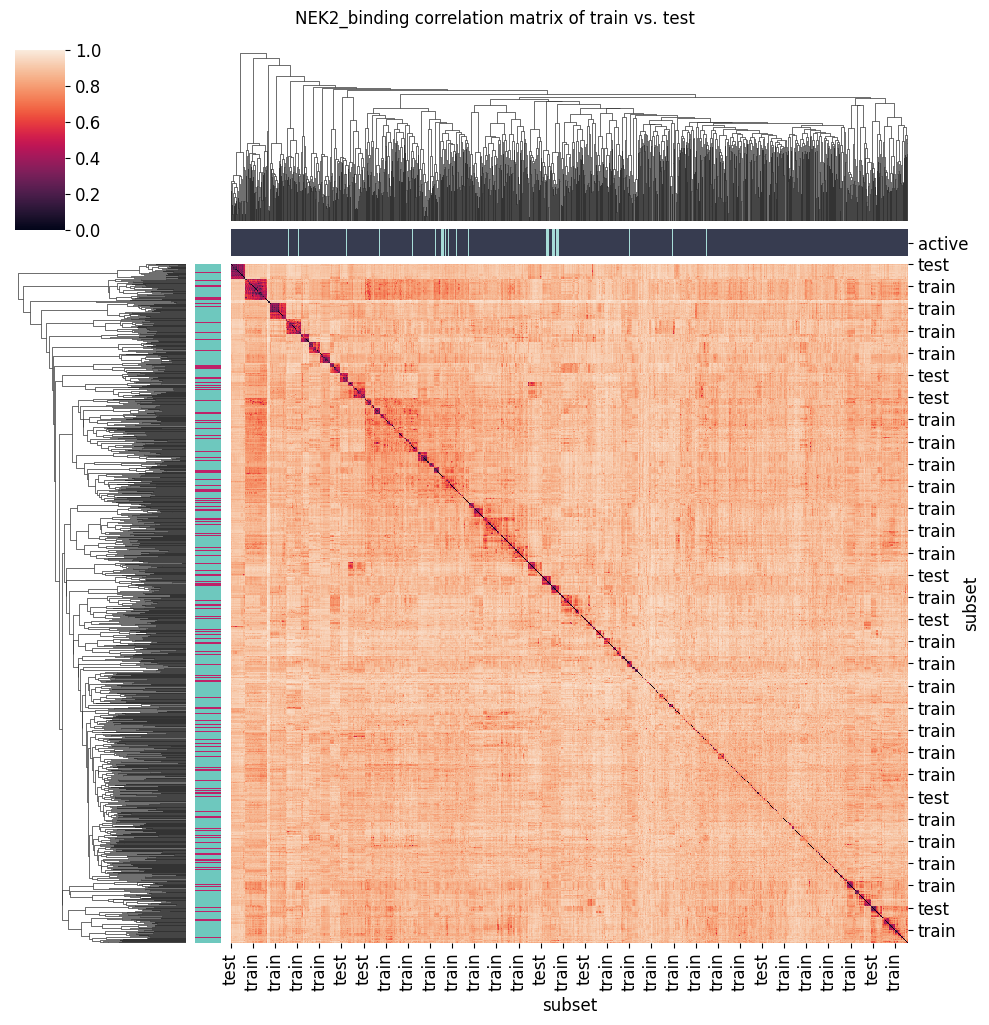

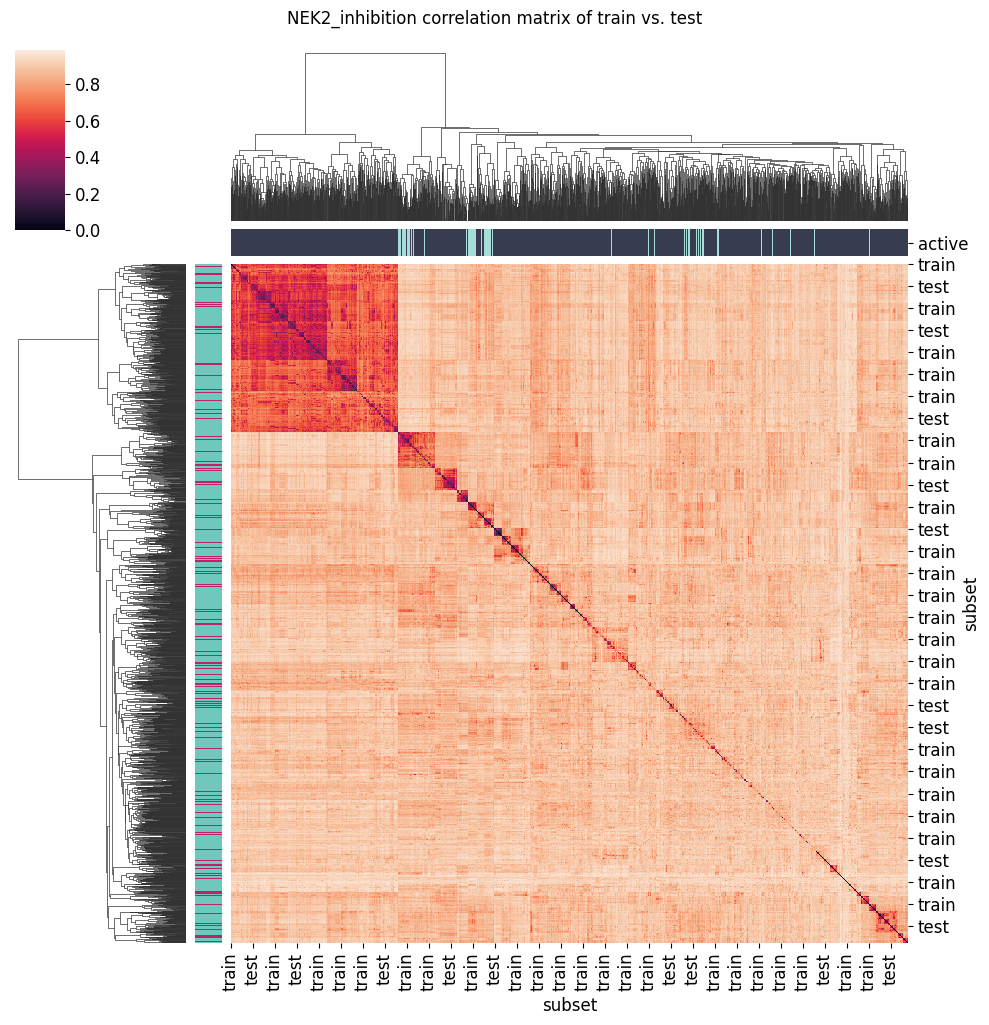

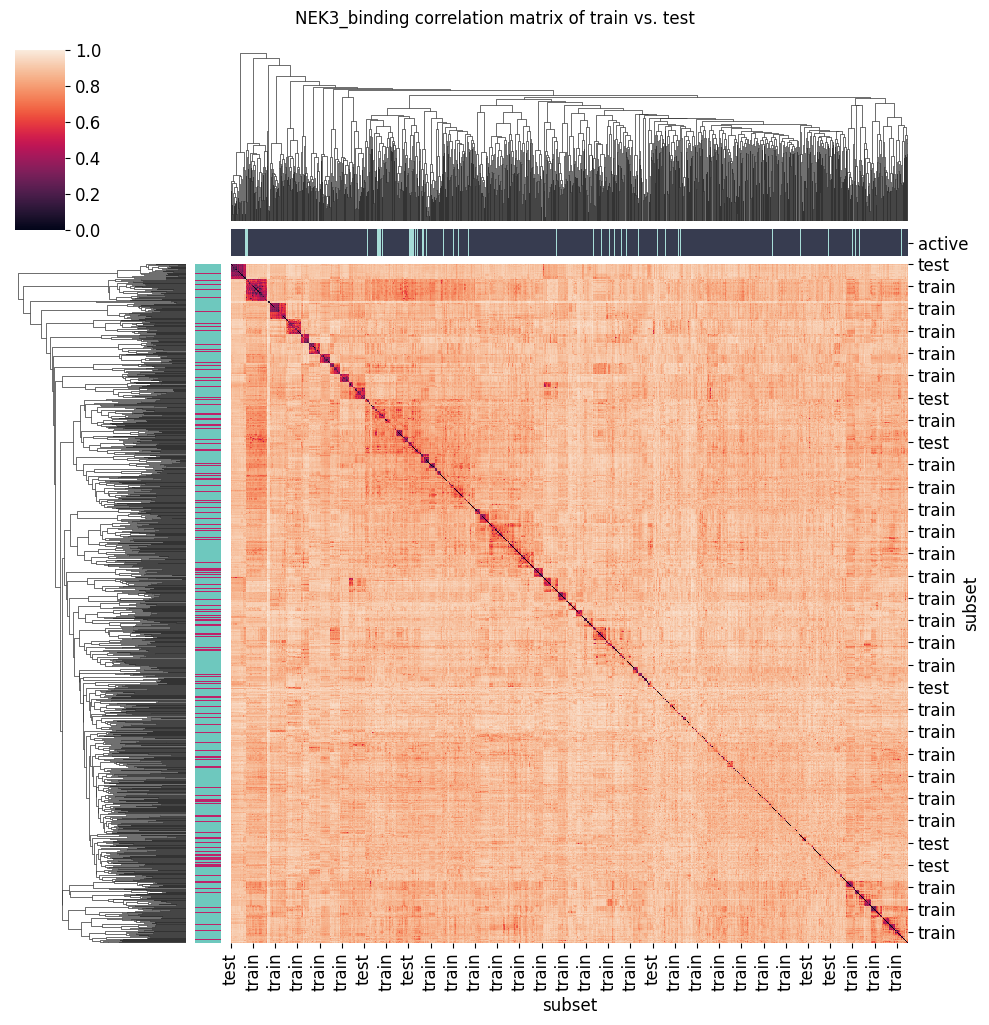

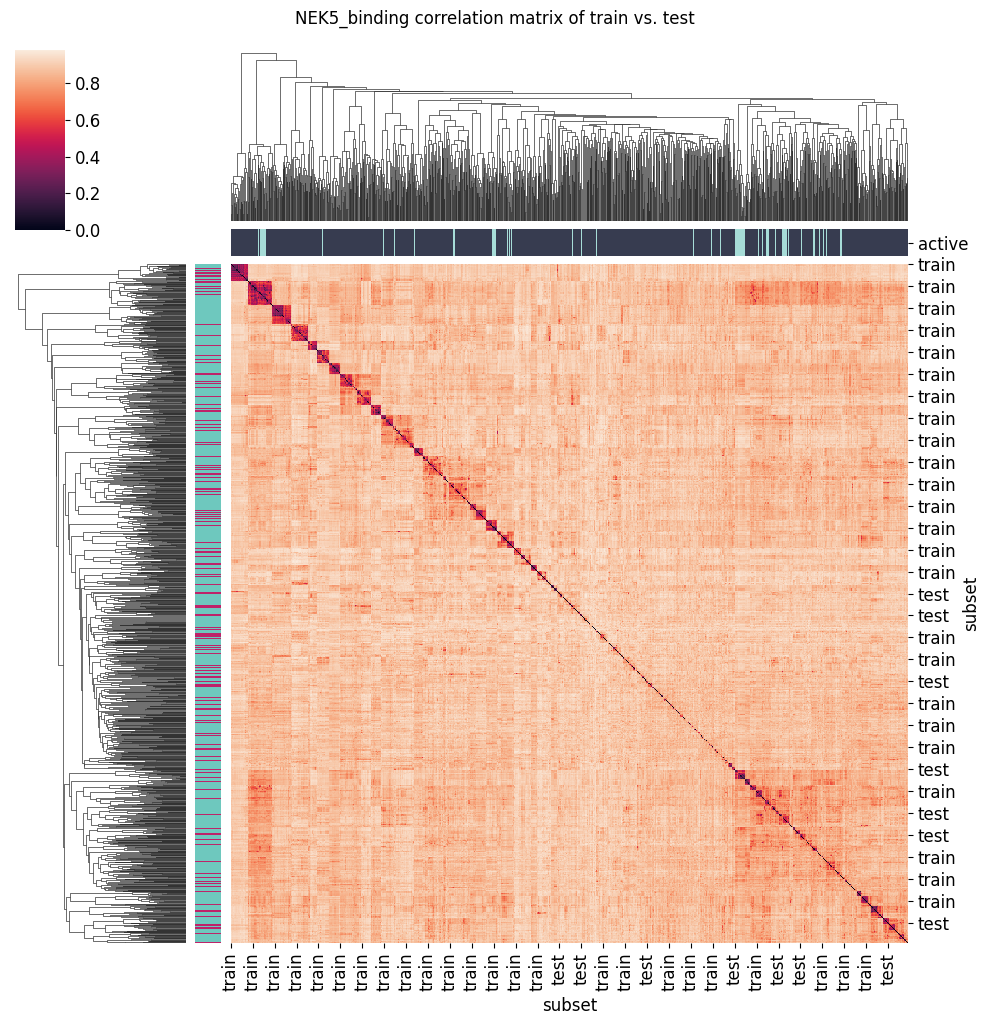

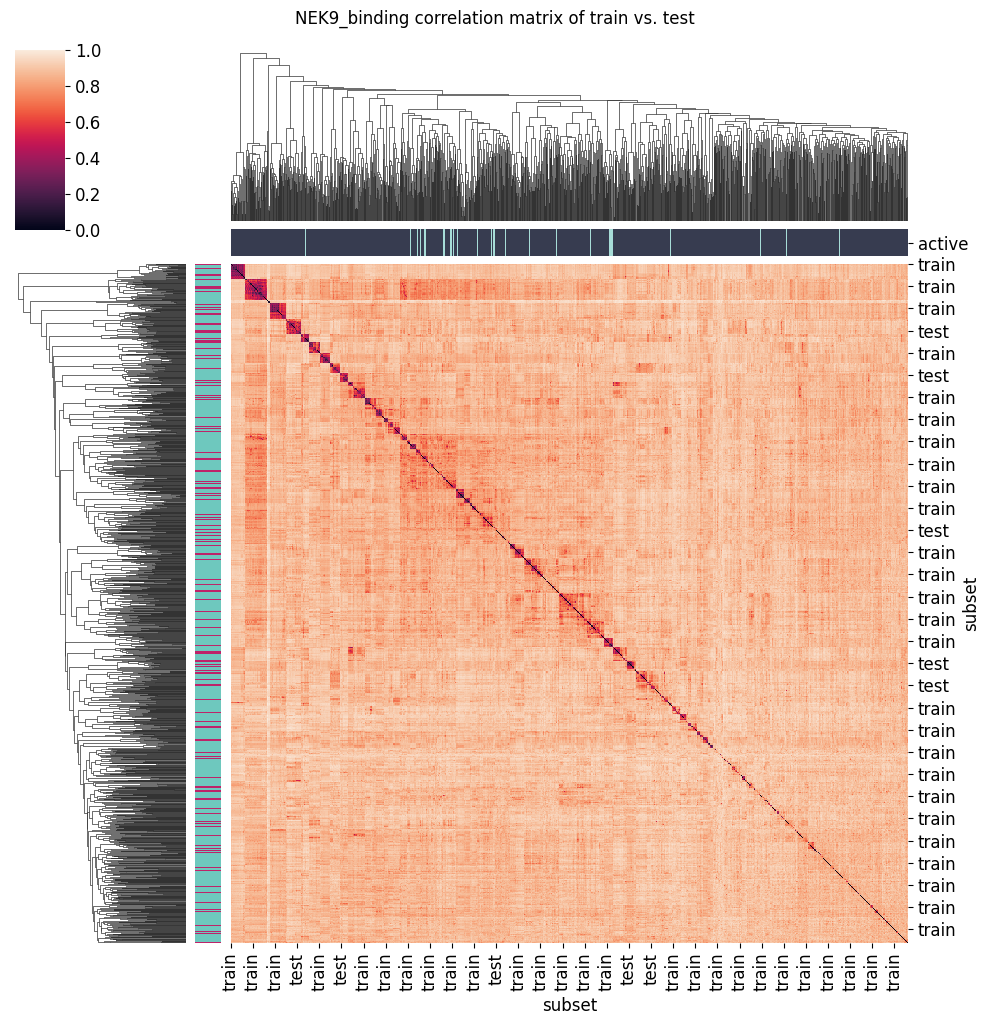

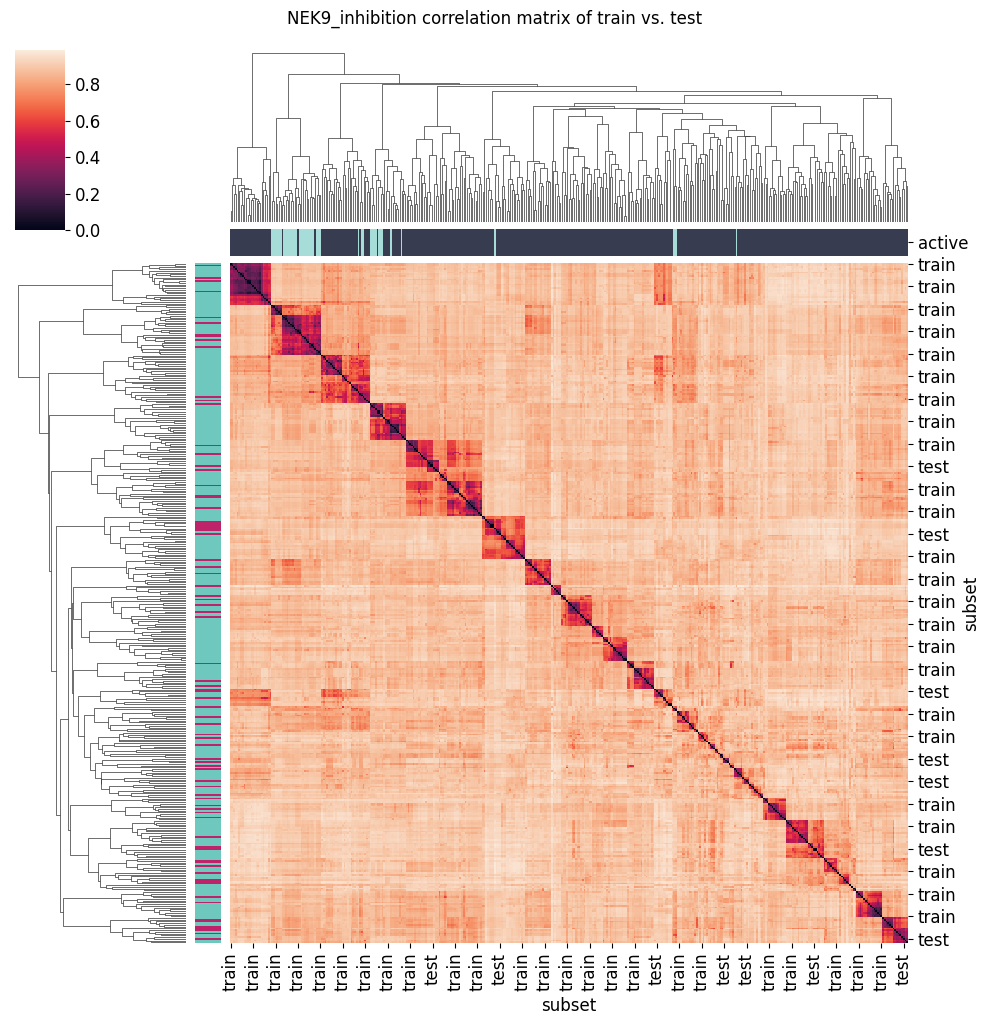

In [25]:
datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
nek2_binding = pd.read_csv(f'{datapath}NEK2_binding_MFP_none_scaled.csv') 
nek2_binding
drop_cols=['NEK', 'compound_id', 'base_rdkit_smiles']
mfp_dict = {}
for i in range (2048): 
    mfp_dict[str(i)] = f'ecfp_2048_{i}'
neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition']
for nek in neks: 
    mfp_df = pd.read_csv(f'{datapath}{nek}_MFP_none_scaled.csv').rename(columns=mfp_dict)
    corr_matrices, figures =plot_corr_matrices_ecfp_traintest(dfs=[mfp_df], dflabs=[f'{nek}'])

In [24]:
nek2_binding

NEK compound_id  \
0     NEK2_binding      kdb_10   
1     NEK2_binding     kdb_100   
2     NEK2_binding    kdb_1003   
3     NEK2_binding     kdb_101   
4     NEK2_binding     kdb_102   
...            ...         ...   
1403  NEK2_binding    kdb_2955   
1404  NEK2_binding    kdb_3034   
1405  NEK2_binding      kdb_51   
1406  NEK2_binding     kdb_980   
1407  NEK2_binding      kdb_99   

                                      base_rdkit_smiles subset  active  \
0     CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...  train       0   
1     C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...  train       0   
2     CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...  train       0   
3     COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...  train       0   
4     COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...  train       0   
...                                                 ...    ...     ...   
1403    c1cncc(-c2ccc3nc(Nc4ccc(CN5CCOCC5)cc4)ncc3c2)c1  train       1   
1404         O=C(NC1CCNCC1)c1n[nH]cc1NC(=O)c1c(F)cccc1F  train       1   
1405  CCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)...  train       1   
1406  Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...   test       1   
1407  C[C@@H](Oc1cc(-n2cnc3ccc(CN4CCN(C)CC4)cc32)sc1...  train       1   

      ecfp_2048_0  ecfp_2048_1  ecfp_2048_2  ecfp_2048_3  ecfp_2048_4  ...  \
0               0            0            0            0            0  ...   
1               0            1            0            0            0  ...   
2               0            0            0            0            0  ...   
3               0            0            0            0            0  ...   
4               0            0            0            0            0  ...   
...           ...          ...          ...          ...          ...  ...   
1403            0            0            0            0            0  ...   
1404            0            0            0            0            0  ...   
1405            0            0            0            0            0  ...   
1406            0            0            0            0            0  ...   
1407            0            1            0            0            0  ...   

      ecfp_2048_2038  ecfp_2048_2039  ecfp_2048_2040  ecfp_2048_2041  \
0                  0               0               0               0   
1                  0               0               0               0   
2                  0               0               0               0   
3                  0               0               0               1   
4                  0               0               0               0   
...              ...             ...             ...             ...   
1403               0               0               0               0   
1404               0               0               0               0   
1405               0               0               0               0   
1406               0               0               0               0   
1407               0               0               0               0   

      ecfp_2048_2042  ecfp_2048_2043  ecfp_2048_2044  ecfp_2048_2045  \
0                  0               0               0               0   
1                  0               0               0               0   
2                  0               0               0               0   
3                  0               0               0               0   
4                  0               0               0               0   
...              ...             ...             ...             ...   
1403               0               0               0               0   
1404               0               0               0               0   
1405               0               0               0               0   
1406               0               0               0               0   
1407               0               0               0               0   

      ecfp_2048_2046  ecfp_2048_2047  
0          

In [18]:
# datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
# nek2moesmote = pd.read_csv(f'{datapath}NEK2_binding_MOE_SMOTE.csv') 
# nek2mfpsmote = pd.read_csv(f'{datapath}NEK2_binding_MFP_SMOTE.csv') 
# nek2_desc = pd.read_csv(f'{datapath}NEK2_binding_MOE_none_scaled.csv') 
# nek2_mfp = pd.read_csv(f'{datapath}NEK2_binding_MFP_none_scaled.csv') 
# mfp_dict = {}
# for i in range (2048): 
#     mfp_dict[str(i)] = f'ecfp_2048_{i}'
# # nek2_og = nek2_desc.merge(nek2_mfp, on=['compound_id', 'base_rdkit_smiles', 'subset', 'fold', 'active'])
# nek2_og = nek2_desc.merge(nek2_mfp, on=['NEK','compound_id', 'base_rdkit_smiles', 'subset', 'active'])
# nek2_og= nek2_og.rename(columns=mfp_dict)

# nek2moe_under = pd.read_csv(f'{datapath}NEK2_binding_MOE_UNDER.csv')
# nek2mfp_under = pd.read_csv(f'{datapath}NEK2_binding_MFP_UNDER.csv')
# # nek2_under = nek2moe_under.merge(nek2mfp_under, on=['NEK','compound_id', 'base_rdkit_smiles', 'subset', 'fold', 'active'])
# nek2_under = nek2moe_under.merge(nek2mfp_under, on=['NEK','compound_id', 'base_rdkit_smiles', 'subset', 'active'])
# nek2_under = nek2_under[nek2_under['subset'] == 'train']
# nek2_under = nek2_under.rename(columns=mfp_dict)
# nek2_under 
# nek2_under['subset'] = 'undersampled' 
# nek2_og = pd.concat([nek2_og, nek2_under])
# # nek2_under =nek2_under[~nek2_under.base_rdkit_smiles.isin(nek2_og.base_rdkit_smiles)]
# # nek2_under
# common_cols = ['NEK','base_rdkit_smiles', 'compound_id', 'active', 'subset']
# nek2mfpsmote= nek2mfpsmote.rename(columns=mfp_dict)
# nek2mfpsmote = nek2mfpsmote.drop(columns=common_cols)

# nek2smote = pd.concat([nek2moesmote, nek2mfpsmote], axis=1)
# nek2_smote_train = nek2smote[nek2smote['subset'] == 'train'].copy()

# nek2_og_train = nek2_og[nek2_og['subset']=='train']
# num_train = nek2_og_train.shape[0]
# new_smote=nek2_smote_train.iloc[num_train:].copy()

# new_smote['subset'] = 'smote'
# nek2_all = pd.concat([nek2_og, new_smote])
# print(nek2_all['subset'].value_counts())